In [1]:
import os
import scipy.io as sio
import scipy.misc as smisc
import numpy as np
import re as regexp
import math
import matplotlib.pyplot as plt
import scipy

from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

import scipy.io
import time
import glob,os
import cv2
from scipy import optimize
from pylab import *

There are some problem on digitizer collected HAADF image, HAADF is drifted from 4DSTEM data acquired for some reason, so I had to reassign each thickness to the correct position it correspond to in recon BF image.

## Compute 3D annular averaged datacube on experiment data

In [40]:
path = '/srv/home/chenyu/DEbackup/091618/S6/npy/'
ref = '/srv/home/chenyu/DEbackup/091618/BlankScan/BlankCOMpos.npy'   # path for center detected on empty scan
# generate datacube to save 4Ddata
datacube = np.zeros([150,150,512,512])
PACBED = np.zeros([512,512])
offset = 0     # offset is zero for data acquired in slave mode

ix = 45
iy = 99
# load raw dataset

filenum = ix*150+iy+offset+1
datacube[ix,iy,:,:] = np.load(path+'S6_'+format(filenum,'05')+'.npy')
PACBED = PACBED+datacube[ix,iy,:,:]
            
PACBED = PACBED/ix/iy


ref = np.load(ref)
radius_min = np.amin(ref[2:-1,:,:])
AnnularInt = np.zeros((datacube.shape[0],datacube.shape[1],math.floor(radius_min)))


frame = datacube[ix,iy,:,:]
cy = ref[ix,iy,1]
cx = ref[ix,iy,0]
# cx = 258
# cy = 224
kx = np.linspace(-cx,datacube.shape[2]-cx,datacube.shape[2])
ky = np.linspace(-cy,datacube.shape[3]-cy,datacube.shape[3])
kx2,ky2 = np.meshgrid(kx,ky)
distance_from_center = np.sqrt(kx2**2 + ky2**2)

for dist in range(AnnularInt.shape[2]):
    mask = (dist <= distance_from_center) & (distance_from_center <= dist+1)
    mask = mask*1
    AnnularInt[ix,iy,dist] = np.sum(frame*mask)/np.sum(mask)


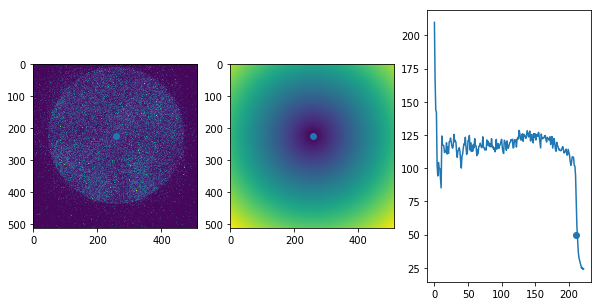

In [41]:
# plt.plot(AnnularInt[ix,iy,:])
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(datacube[ix,iy,:,:])
cx = ref[ix,iy,0]
cy = ref[ix,iy,1]
axes[0].scatter(cx,cy)
# print(cx,cy)
axes[1].imshow(distance_from_center)
axes[1].scatter(cx,cy)
axes[2].plot(AnnularInt[ix,iy,:])
ang = 208
axes[2].scatter(210,50)

[  0   0   0 ... 237 237 237]


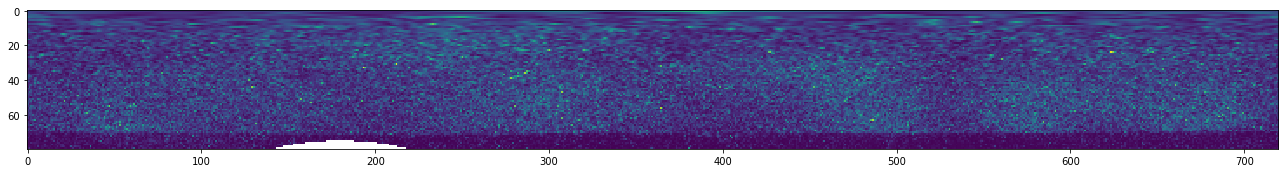

In [212]:
test = convert(datacube[ix,iy,:,:])
fig, ax = subplots(figsize=(18, 9))
ax.imshow(test)
tight_layout()

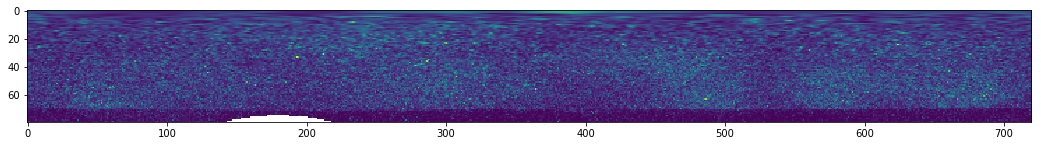

In [215]:
fig, ax = subplots(figsize=(18, 18))
ax.imshow(test)


In [211]:
from scipy.interpolate import griddata
from numpy import exp, abs,angle

def convert (img, size= [512,512], center=[cx,cy], correction=False, plot=False):
    '''
    :param img: a 2-d array for the image to convert to polar coordinates
    :param center: x,y coordinates for the center of the image
    :param correction: the circular correction
    :param size: [x,y] describing the pixel dimensions of the photo
    :return: polar_img r vs. theta
    '''
    phase_width = 720
    r_inital = 0
    r_final =240
    final_theta, final_r = create_grid(np.linspace(-1*np.pi,np.pi,phase_width),np.arange(0,r_final,3))
    initial_x, initial_y = create_grid(range(1,513),range(1,513))
    print(final_r)
    final_x, final_y = polar_list_to_cartesian(final_r,final_theta,center)
    #initial_theta, initial_r = cartesian_list_to_polar(initial_x,initial_y,center)
    inten = np.reshape(img,size[0]*size[1])
    polar_img = griddata((initial_x,initial_y),inten,(final_x,final_y), method='linear')
    polar_img = np.reshape(polar_img, [80, phase_width])
    if plot:
        plt.imshow(polar_img, extent=(0, 6.293, 0, 6))
        plt.show()
    return polar_img

def cartesian_to_polar(x,y,center):
    '''
    A function that converts the x,y coordinates to polar ones.
    -Does not do the circular correction
    '''
    corrected_x= x-center[0]
    corrected_y= y-center[1]
    theta = np.arctan2(corrected_y,corrected_x)
    r = np.sqrt(corrected_x**2+ corrected_y**2)
    return theta,r

def polar_to_cartesian(r, theta, center):
    x = center[0]+r*np.cos(theta)
    y = center[1] +r*np.sin(theta)
    return x,y

def cartesian_list_to_polar(x_list,y_list,center):
    theta_list = []
    r_list = []
    for x,y in zip(x_list,y_list):
        t,r =cartesian_to_polar(x,y,center)
        theta_list.append(t)
        r_list.append(r)
    return theta_list, r_list

def polar_list_to_cartesian(r_list,theta_list, center):
    x_list = []
    y_list = []
    for r, t in zip(r_list,theta_list):
        x,y = polar_to_cartesian(r,t,center)
        x_list.append(x)
        y_list.append(y)
    return x_list,y_list

def create_grid (dimension1,dimension2):
    '''
    Takes data from array of points turns it into a grid of coordinates
    '''
    dim1,dim2 =np.meshgrid(dimension1,dimension2)
    size = len(dimension1)*len(dimension2)
    a,b = np.reshape(dim1,size),np.reshape(dim2,size)
    return a,b

def circular_grid_data(intial_r, initial_theta, intensity, final_r,final_theta):
    #interpolating the radi and theta values from the cartesian points and mapping the intesities to evenly spaced
    # points in r an theta through linear interpolation... possibly some other interpolation....
    #for r,t in zip(final_r,final_theta):

    return


#Tests
'''
x,y = create_grid(range(0,10),range(0,10))
r,t = cartesian_list_to_polar(x,y,[5,5])
plt.plot(r,t)
plt.show()'''

'\nx,y = create_grid(range(0,10),range(0,10))\nr,t = cartesian_list_to_polar(x,y,[5,5])\nplt.plot(r,t)\nplt.show()'

In [983]:
path = '/srv/home/chenyu/DEbackup/091618/S6/npy/'
ref = '/srv/home/chenyu/DEbackup/091618/BlankScan/BlankCOMpos.npy'   # path for center detected on empty scan
# generate datacube to save 4Ddata
datacube = np.zeros([150,150,512,512])
PACBED = np.zeros([512,512])
offset = 0     # offset is zero for data acquired in slave mode

# load raw dataset
for ix in range(datacube.shape[0]):
        for iy in range(datacube.shape[1]):
            filenum = ix*150+iy+offset+1
            datacube[ix,iy,:,:] = np.load(path+'S6_'+format(filenum,'05')+'.npy')
            PACBED = PACBED+datacube[ix,iy,:,:]
            
PACBED = PACBED/ix/iy


ref = np.load(ref)
radius_min = np.amin(ref[2:-1,:,:])
AnnularInt = np.zeros((datacube.shape[0],datacube.shape[1],math.floor(radius_min)))

for ix in range(AnnularInt.shape[0]):
    for iy in range(AnnularInt.shape[1]):
        frame = datacube[ix,iy,:,:]
        # center position of x and y needs to be reversed when generate masks
        cx = ref[ix,iy,0]
        cy = ref[ix,iy,1]
#         cx = 258
#         cy = 224
        kx = np.linspace(-cx,datacube.shape[2]-cx,datacube.shape[2])
        ky = np.linspace(-cy,datacube.shape[3]-cy,datacube.shape[3])
        kx2,ky2 = np.meshgrid(kx,ky)
        distance_from_center = np.sqrt(kx2**2 + ky2**2)

        for dist in range(AnnularInt.shape[2]):
            mask = (dist <= distance_from_center) & (distance_from_center <= dist+1)
            mask = mask*1
            AnnularInt[ix,iy,dist] = np.sum(frame*mask)/np.sum(mask)

# AnnularInt_2.npy uses center of PACBED as cx and cy, instead of using COM center from blank scan
np.save(path + 'AnnularInt.npy', AnnularInt)
del datacube

## Refine peak positions in HAADF to match ABF images

### Rough align HAADF peaks to 4DSTEM peak positions

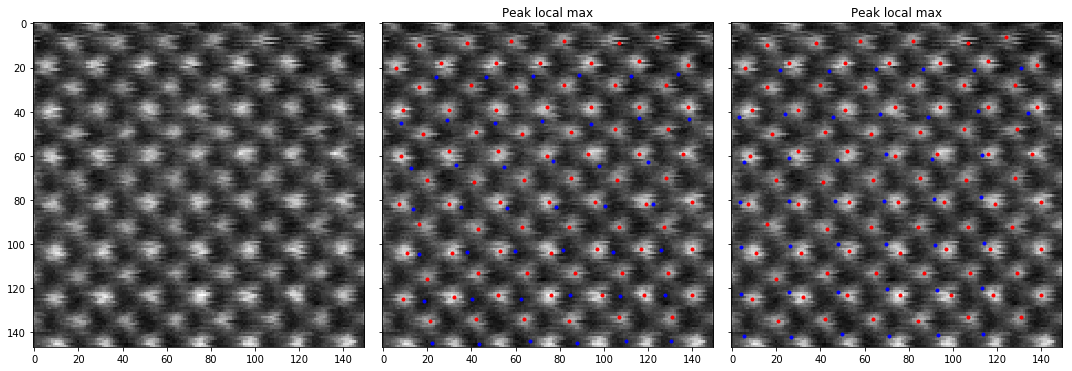

In [125]:
HAADFpeaks = sio.loadmat('/srv/home/chenyu/DEbackup/091618/S3/SrPeaks.mat')
peaks_x = HAADFpeaks['peak_x']
peaks_y = HAADFpeaks['peak_y']
BF = np.load('/srv/home/chenyu/DEbackup/091618/S6/BF.npy')
im = img_as_float(np.max(BF[2:-1,:])-BF[2:-1,:])

image_max = ndi.gaussian_filter(im, 2)

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=5)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im,cmap=plt.cm.gray)

ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].autoscale(False)
ax[1].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1].plot(peaks_x,peaks_y,'b.')
# ax[2].axis('off')
ax[1].set_title('Peak local max')

peaks_y = peaks_y - 3
peaks_x = peaks_x - peaks_y*17/144

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].plot(peaks_x,peaks_y,'b.')
# ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [94]:
def gaussianx2(xdata_tuple,bg,height, center_x, center_y, width_x, width_y):

    (x, y) = xdata_tuple
    width_x = float(width_x)
    width_y = float(width_y)
    g = height*exp(
                 -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)+bg
    return g.ravel()

def fitGaussianx2(data, guess, bounds):
    x = np.linspace(0, patch.shape[1]-1, patch.shape[1])
    y = np.linspace(0, patch.shape[0]-1, patch.shape[0])
    x, y = np.meshgrid(x, y)
    xdata_tuple = (x,y)
    popt, pcov = optimize.curve_fit(gaussianx2, xdata_tuple, data.ravel(), p0=guess,bounds=bounds,method='trf',verbose=0,maxfev=100000)
    return popt


7 19
[7.12829279e+05 6.12241646e+05 5.58455404e+00 7.21654603e+00
 3.81804231e+00 3.13071010e+00]
5.584554041712297 7.216546027976719
5.584554041712298 19.21654602797672


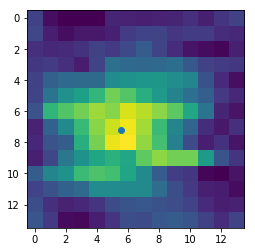

In [95]:
x = int(peaks_x[0][0])
y = int(peaks_y[0][0])
print(x,y)
patch = im[y-7:y+7,x-7:x+7]
plt.imshow(patch)
bg = np.amin(patch)
guess = (bg,im[7,7]-bg,7, 7, 3, 3)
bounds = ([0,0,0,0,1,1],[np.inf,np.inf,14,14,10,10])
param = fitGaussianx2(patch, guess, bounds)
print(param)
plt.scatter(param[2],param[3])
print(param[2],param[3])
print(param[2]+x-7,param[3]+y-7)

### Fine tune each peak position using 2D Guassian fit

([], <a list of 0 Text yticklabel objects>)

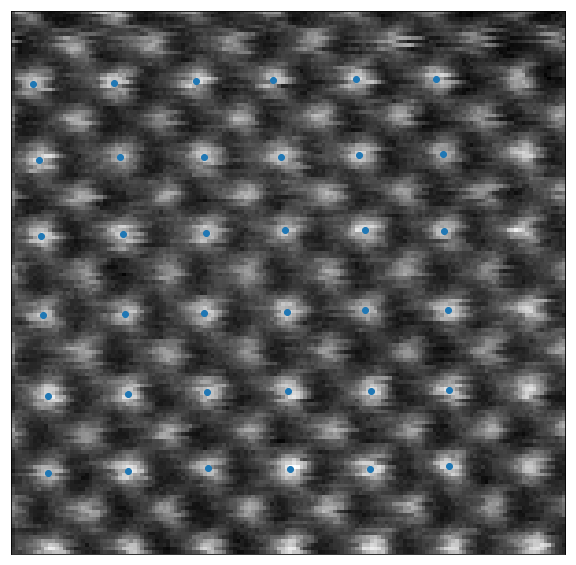

In [118]:
peaks_x_fit = []
peaks_y_fit = []
for i in range(peaks_y.shape[0]):
    
    x = int(peaks_x[i][0])
    y = int(peaks_y[i][0])
    
    patch = im[y-7:y+7,x-7:x+7]
    bg = np.amin(patch)
    guess = (bg,im[7,7]-bg,7, 7, 3, 3)
    bounds = ([0,0,0,0,1,1],[np.inf,np.inf,14,14,10,10])
    param = fitGaussianx2(patch, guess, bounds)
    
    peaks_x_fit.append(param[2]+x-7)
    peaks_y_fit.append(param[3]+y-7)

fig = plt.figure(figsize=(10,10))
plt.imshow(im,cmap=plt.cm.gray)
plt.scatter(peaks_x_fit,peaks_y_fit)
plt.xticks([])
plt.yticks([])


In [119]:
peaks_x_fit = np.asarray(peaks_x_fit)
peaks_y_fit = np.asarray(peaks_y_fit)
np.save('/srv/home/chenyu/DEbackup/091618/S6/SrPeaks_x.npy',np.asarray(peaks_x_fit))
np.save('/srv/home/chenyu/DEbackup/091618/S6/SrPeaks_y.npy',np.asarray(peaks_y_fit))

## Calculate pct difference for annular integrated 3D cube at target region

In [2]:
import statistics

path = '/srv/home/chenyu/DEbackup/091618/S6/'
simpath = '/srv/home/chenyu/antisite/PRISMATIC/'

AnnularInt = np.load(path+'npy/AnnularInt_2.npy')

# target file should satisfy 27-depth+slice=target thickness
thickness_target = 9 #target thickness for atom column in unit cells
range_r = 5 # real space integration range in pixel, 1px = 0.15 Angstrom in sim library
range_angle = 9

peaks_x = np.load('/srv/home/chenyu/DEbackup/091618/S6/SrPeaks_x.npy')
peaks_y = np.load('/srv/home/chenyu/DEbackup/091618/S6/SrPeaks_y.npy')
thickness = sio.loadmat(path+'HAADFprediction_r8.mat')
thickness = thickness['peak_int']

weights = np.ones([range_r,range_r,range_angle])
weights = weights/np.sum(weights)

for depth in range(27-thickness_target,26):
    
    slice = thickness_target+depth-27
    savingName = 'AnnularIntDiffPct_depth_' + str(depth) + '_slice' + str(slice) + '.npy'
    
     # Find one window inside the zero disk
    difference = np.load(simpath + 'Depth' + str(depth) + '/' + savingName)
    difference = difference[:,:,10:54]
    print(depth,slice)
    
    # ndimage.convolve won't change size of matrix
    # maximum element in convoluted matrix is the position for window center
    difference_conv = ndimage.convolve(difference, weights, mode='constant', cval=0.0)

    max_pos = np.unravel_index(np.argmax(difference_conv, axis=None), difference_conv.shape)
    max_val = np.amax(difference_conv)
    
    min_pos = np.unravel_index(np.argmin(difference_conv, axis=None), difference_conv.shape)
    min_val = np.amin(difference_conv)

    int_list = []
    int_list_2 = []
    
    print("Inside zero disk:")
    
    for i in range(thickness.shape[0]):
        if thickness[i] < 0.3905*thickness_target+0.001 and thickness[i] > 0.3905*thickness_target-0.001:
            x = int(peaks_x[i])
            y = int(peaks_y[i])+2
            if x<140 and y<140:
                
                # max_pos-2-18.5, 2 for offset generated by convolution, 18.5 for center in simulation data
            
                x_start = int(round(x+(max_pos[0]-2-18.5)/18.5*15))
                y_start = int(round(y+(max_pos[1]-2-18.5)/18.5*15))
                ang_start = int(round((max_pos[2]-4+10)/96*420))

                sub_datacube = AnnularInt[x_start:x_start+6,y_start:y_start+6,ang_start:ang_start+40]
                sub_datacube = AnnularInt[y_start:y_start+6,x_start:x_start+6,ang_start:ang_start+40]
                int_list.append(np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2])
                
#                 print("Average intensity for Sr site at %.1f %.1f: %.2f" % (x,y,np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2]))

                x_start = int(round(x+(min_pos[0]-2-18.5)/18.5*15))
                y_start = int(round(y+(min_pos[1]-2-18.5)/18.5*15))
                ang_start = int(round((min_pos[2]-4+10)/96*420))

                sub_datacube = AnnularInt[x_start:x_start+6,y_start:y_start+6,ang_start:ang_start+40]
                sub_datacube = AnnularInt[y_start:y_start+6,x_start:x_start+6,ang_start:ang_start+40]
                int_list_2.append(np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2])
                
#                 print("Average intensity for Sr site at %.1f %.1f: %.2f" % (x,y,np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2]))


    int_list_mean = sum(int_list)/float(len(int_list))
    int_list_std = statistics.stdev(int_list)/int_list_mean
    print("Target window1 starting at: %d, %d, %d ,change by %.2f pct." % (max_pos[0]-2,max_pos[1]-2,max_pos[2]-4,max_val*100))
    print("Standard deviation for window1 is %.2f pct" % (int_list_std*100))
    
    int_list_mean = sum(int_list_2)/float(len(int_list_2))
    int_list_std = statistics.stdev(int_list_2)/int_list_mean
    print("Target window2 starting at: %d, %d, %d ,change by %.2f pct." % (min_pos[0]-2,min_pos[1]-2,min_pos[2]-4,min_val*100))
#     print("Window2 correspond to %d, %d, %d at experiment data." % (x_start, y_start, ang_start))
    print("Standard deviation for window2 is %.2f pct" % (int_list_std*100))
   
    int_list_mean = sum(int_list_2)/float(len(int_list_2))


18 0
Inside zero disk:
Target window1 starting at: 23, 18, 0 ,change by 5.25 pct.
Standard deviation for window1 is 1.73 pct
Target window2 starting at: 24, 19, 35 ,change by -8.43 pct.
Standard deviation for window2 is 1.30 pct
19 1
Inside zero disk:
Target window1 starting at: 22, 19, 0 ,change by 4.53 pct.
Standard deviation for window1 is 1.80 pct
Target window2 starting at: 17, 25, 35 ,change by -8.50 pct.
Standard deviation for window2 is 1.69 pct
20 2
Inside zero disk:
Target window1 starting at: 21, 18, 0 ,change by 4.71 pct.
Standard deviation for window1 is 1.89 pct
Target window2 starting at: 23, 19, 35 ,change by -10.72 pct.
Standard deviation for window2 is 1.30 pct
21 3
Inside zero disk:
Target window1 starting at: 19, 17, 0 ,change by 4.83 pct.
Standard deviation for window1 is 1.89 pct
Target window2 starting at: 23, 18, 35 ,change by -9.97 pct.
Standard deviation for window2 is 1.30 pct
22 4
Inside zero disk:
Target window1 starting at: 18, 17, 0 ,change by 7.30 pct.
S

([], <a list of 0 Text yticklabel objects>)

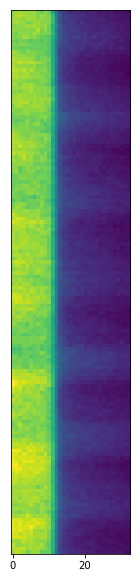

In [4]:
fig = plt.figure(figsize=(10,10))
temp = np.sum(AnnularInt[62:63,:,:],axis=0)
temp = AnnularInt[60,:,200:-1]
plt.imshow(temp)
# plt.xticks([])
plt.yticks([])

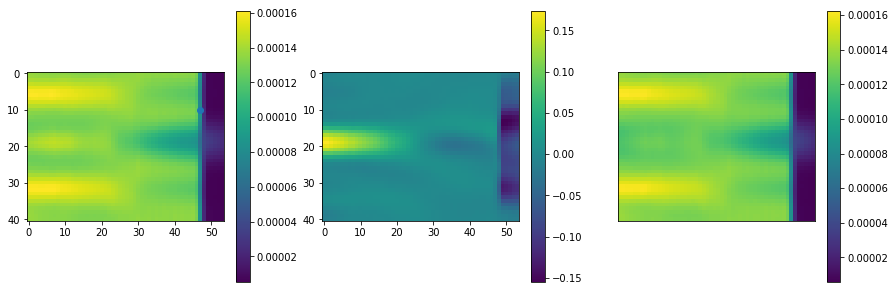

In [50]:

temp =  np.load(simpath + 'Depth' + str(depth) + '/COM_depth' + str(depth) + '_slice' + str(slice) + '_90AnnularInt.npy')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

im0 = ax[0].imshow(temp[19,:,0:54])
fig.colorbar(im0,ax=ax[0])
ax[0].scatter(47,10)

difference = np.load(simpath + 'Depth' + str(depth) + '/' + savingName)
im1 = ax[1].imshow(difference[19,:,0:54])
fig.colorbar(im1,ax=ax[1])

temp = np.load(simpath+'Depth0/COM_depth0_slice' +str(26-depth+slice)+'_90AnnularInt.npy')
im2 = ax[2].imshow(temp[19,:,0:54])
fig.colorbar(im2,ax=ax[2])

plt.xticks([])
plt.yticks([])
plt.show()

### Manually select fixed window position for antisite detection
#### Cone shaped window start at center and a window outside zero disk
This cone shaped window center at Sr atom should be able to capture difference caused by shallow defect

In [762]:
import statistics
mask_size = (5,5,40)
mask_center = (0,0,44)
path = '/srv/home/chenyu/DEbackup/091618/S6/'
thickness_target = 9
int_list = []
for i in range(thickness.shape[0]):
        if thickness[i] < 0.3905*thickness_target+0.001 and thickness[i] > 0.3905*thickness_target-0.001:
            x = int(peaks_x[i])
            y = int(peaks_y[i])
            x_start = int(x + mask_center[0] - (mask_size[0]-1)/2)
            y_start = int(y + mask_center[1] - (mask_size[1]-1)/2)
            ang_start = int(mask_center[2])

            sub_datacube = AnnularInt[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
            int_list.append(np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2])
            print("Average intensity for Sr site at %.1f %.1f: %.2f" % (x,y,np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2]))

            
int_list_mean = sum(int_list)/float(len(int_list))
int_list_std = statistics.stdev(int_list)/int_list_mean
print("Standard deviation for window1 is %.2f pct" % (int_list_std*100))

Average intensity for Sr site at 7.0 19.0: 114.50
Average intensity for Sr site at 50.0 18.0: 120.52
Average intensity for Sr site at 71.0 18.0: 124.09
Average intensity for Sr site at 116.0 18.0: 123.73
Average intensity for Sr site at 52.0 38.0: 132.63
Average intensity for Sr site at 95.0 37.0: 129.04
Average intensity for Sr site at 75.0 58.0: 121.52
Average intensity for Sr site at 117.0 58.0: 126.68
Average intensity for Sr site at 9.0 81.0: 123.90
Average intensity for Sr site at 30.0 79.0: 131.11
Average intensity for Sr site at 52.0 80.0: 130.16
Average intensity for Sr site at 96.0 80.0: 124.38
Average intensity for Sr site at 118.0 102.0: 120.76
Average intensity for Sr site at 10.0 124.0: 130.08
Average intensity for Sr site at 53.0 123.0: 124.40
Standard deviation for window1 is 3.89 pct


In [763]:
mask_size = (6,6,10)
mask_center = (0,0,10)
for depth in range(27-thickness_target,26):
    
    slice = thickness_target+depth-27
    savingName = 'AnnularIntDiffPct_depth_' + str(depth) + '_slice' + str(slice) + '.npy'
    
     # Find one window inside the zero disk
    difference = np.load(simpath + 'Depth' + str(depth) + '/' + savingName)
    x_start = int(18.5 + mask_center[0] - (mask_size[0]-1)/2)
    y_start = int(18.5+ mask_center[1] - (mask_size[1]-1)/2)
    ang_start = int(mask_center[2])
    sub_datacube = difference[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
    print('Target difference for depth %d is %.2f' % (depth,np.average(sub_datacube)*100))


Target difference for depth 18 is -1.86
Target difference for depth 19 is 0.02
Target difference for depth 20 is 2.01
Target difference for depth 21 is 3.47
Target difference for depth 22 is 6.15
Target difference for depth 23 is 6.82
Target difference for depth 24 is 8.60
Target difference for depth 25 is 7.57


### Window on dark field region

In [764]:
import statistics
mask_size = (5,5,40)
mask_center = (5,1.5,210)
path = '/srv/home/chenyu/DEbackup/091618/S6/'
thickness_target = 9
int_list = []
for i in range(thickness.shape[0]):
        if thickness[i] < 0.3905*thickness_target+0.001 and thickness[i] > 0.3905*thickness_target-0.001:
            x = int(peaks_x[i])
            y = int(peaks_y[i])
            x_start = int(x + mask_center[0] - (mask_size[0]-1)/2)
            y_start = int(y + mask_center[1] - (mask_size[1]-1)/2)
            ang_start = int(mask_center[2])

            sub_datacube = AnnularInt[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
            int_list.append(np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2])
            print("Average intensity for Sr site at %.1f %.1f: %.2f" % (x,y,np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2]))

            
int_list_mean = sum(int_list)/float(len(int_list))
int_list_std = statistics.stdev(int_list)/int_list_mean
print("Standard deviation for window1 is %.2f pct" % (int_list_std*100))

Average intensity for Sr site at 7.0 19.0: 35.09
Average intensity for Sr site at 50.0 18.0: 34.37
Average intensity for Sr site at 71.0 18.0: 34.29
Average intensity for Sr site at 116.0 18.0: 30.82
Average intensity for Sr site at 52.0 38.0: 30.91
Average intensity for Sr site at 95.0 37.0: 32.26
Average intensity for Sr site at 75.0 58.0: 31.68
Average intensity for Sr site at 117.0 58.0: 31.15
Average intensity for Sr site at 9.0 81.0: 34.02
Average intensity for Sr site at 30.0 79.0: 31.82
Average intensity for Sr site at 52.0 80.0: 31.82
Average intensity for Sr site at 96.0 80.0: 30.68
Average intensity for Sr site at 118.0 102.0: 31.66
Average intensity for Sr site at 10.0 124.0: 31.42
Average intensity for Sr site at 53.0 123.0: 31.55
Standard deviation for window1 is 4.51 pct


In [765]:
mask_size = (6,6,10)
mask_center = (6,0,49)
for depth in range(27-thickness_target,26):
    
    slice = thickness_target+depth-27
    savingName = 'AnnularIntDiffPct_depth_' + str(depth) + '_slice' + str(slice) + '.npy'
    
     # Find one window inside the zero disk
    difference = np.load(simpath + 'Depth' + str(depth) + '/' + savingName)
    x_start = int(18.5 + mask_center[0] - (mask_size[0]-1)/2)
    y_start = int(18.5+ mask_center[1] - (mask_size[1]-1)/2)
    ang_start = int(mask_center[2])
    sub_datacube = difference[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
    print('Target difference for depth %d is %.2f' % (depth,np.average(sub_datacube)*100))


Target difference for depth 18 is -6.12
Target difference for depth 19 is -3.65
Target difference for depth 20 is -14.27
Target difference for depth 21 is -14.68
Target difference for depth 22 is -16.82
Target difference for depth 23 is -15.92
Target difference for depth 24 is -18.15
Target difference for depth 25 is -13.35


### Scatter plot to visulize different defect thickness and exp data

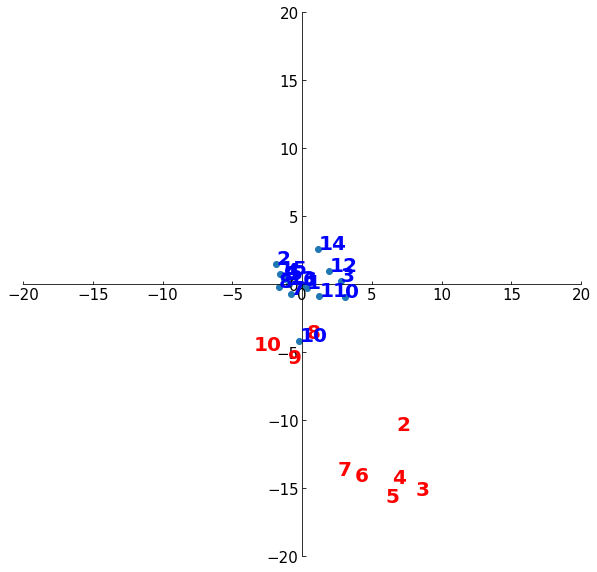

In [206]:
# window1, around Sr column, bright field region, in the order of x,y,angle
mask_size_1_exp = (5,5,44)
mask_center_1_exp = (0,0,44)
mask_size_1_sim = (6,6,10)
mask_center_1_sim = (0,0,10)
# window2, around Ti antisite, dark field regionl, in the order of x,y,angle
mask_size_2_exp = (5,5,27)
mask_center_2_exp = (0,5,222)
# mask_center_2_exp = (0,0,178)


mask_size_2_sim = (6,6,6)
mask_center_2_sim = (0,6,50)
# mask_center_2_sim = (0,0,40)

path = '/srv/home/chenyu/DEbackup/091618/S6/'
thickness = sio.loadmat(path+'HAADFprediction_r8.mat')
thickness = thickness['peak_int']
thickness_target = 10
AnnularInt = np.load(path+'npy/AnnularInt.npy')
peaks_x = np.load('/srv/home/chenyu/DEbackup/091618/S6/SrPeaks_x.npy')
peaks_y = np.load('/srv/home/chenyu/DEbackup/091618/S6/SrPeaks_y.npy')

# scatter plot simulation points
xlist = [] # window1
ylist = [] # window2
for depth in range(27-thickness_target,26):
    slice = thickness_target+depth-27
    savingName = 'AnnularIntDiffPct_depth_' + str(depth) + '_slice' + str(slice) + '.npy'
    difference = np.load(simpath + 'Depth' + str(depth) + '/' + savingName)
    
    x_start = int(18.5 + mask_center_1_sim[0] - (mask_size_1_sim[0]-1)/2)
    y_start = int(18.5+ mask_center_1_sim[1] - (mask_size_1_sim[1]-1)/2)
    ang_start = int(mask_center_1_sim[2])
#     sub_datacube = difference[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
    sub_datacube = difference[y_start:y_start+mask_size_1_sim[1],x_start:x_start+mask_size_1_sim[0],ang_start:ang_start+mask_size_1_sim[2]]
    xlist.append(np.average(sub_datacube)*100) # in percentage
    
    x_start = int(18.5 + mask_center_2_sim[0] - (mask_size_2_sim[0]-1)/2)
    y_start = int(18.5+ mask_center_2_sim[1] - (mask_size_2_sim[1]-1)/2)
    ang_start = int(mask_center_2_sim[2])
#     sub_datacube = difference[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
    sub_datacube = difference[y_start:y_start+mask_size_2_sim[1],x_start:x_start+mask_size_2_sim[0],ang_start:ang_start+mask_size_2_sim[2]]
    ylist.append(np.average(sub_datacube)*100) # in percentage
    
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)

for i in range(len(xlist)):
    ax.text(xlist[i], ylist[i], str(thickness_target-i),color='red',fontweight='bold',fontsize=20)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.axis([-20, 20, -20, 20])

# scatter experiment results
int_list = []
for i in range(thickness.shape[0]):
    if thickness[i] < 0.3905*thickness_target+0.001 and thickness[i] > 0.3905*thickness_target-0.001:
        # y position has 2 px offset as fitting procedure cropped top two rows before fitting
        x = int(peaks_x[i])
        y = int(peaks_y[i])+2
        x_start = int(x + mask_center_1_exp[0] - (mask_size_1_exp[0]-1)/2)
        y_start = int(y + mask_center_1_exp[1] - (mask_size_1_exp[1]-1)/2)
        ang_start = int(mask_center_1_exp[2])

#             sub_datacube = AnnularInt[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
        sub_datacube = AnnularInt[y_start:y_start+mask_size_1_exp[1],x_start:x_start+mask_size_1_exp[0],ang_start:ang_start++mask_size_1_exp[2]]

        int_list.append(np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2])
#             print("Average intensity for Sr site at %.1f %.1f: %.2f" % (x,y,np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2]))

int_list_mean = sum(int_list)/float(len(int_list))
xlist_exp = (int_list - int_list_mean)/int_list_mean

int_list = []
for i in range(thickness.shape[0]):
    if thickness[i] < 0.3905*thickness_target+0.001 and thickness[i] > 0.3905*thickness_target-0.001:
        x = int(peaks_x[i])
        y = int(peaks_y[i])+2
        x_start = int(x + mask_center_2_exp[0] - (mask_size_2_exp[0]-1)/2)
        y_start = int(y + mask_center_2_exp[1] - (mask_size_2_exp[1]-1)/2)
        ang_start = int(mask_center_2_exp[2])

#             sub_datacube = AnnularInt[x_start:x_start+mask_size[0],y_start:y_start+mask_size[1],ang_start:ang_start+mask_size[2]]
        sub_datacube = AnnularInt[y_start:y_start+mask_size_2_exp[1],x_start:x_start+mask_size_2_exp[0],ang_start:ang_start+mask_size_2_exp[2]]

        int_list.append(np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2])
#             print("Average intensity for Sr site at %.1f %.1f: %.2f" % (x,y,np.sum(sub_datacube)/sub_datacube.shape[0]/sub_datacube.shape[1]/sub_datacube.shape[2]))

int_list_mean = sum(int_list)/float(len(int_list))
ylist_exp = (int_list - int_list_mean)/int_list_mean

ax.scatter(xlist_exp*100,ylist_exp*100)
for i in range(len(xlist_exp)):
    ax.text(xlist_exp[i]*100, ylist_exp[i]*100, str(i),color='blue',fontweight='bold',fontsize=20)

ax.tick_params(labelsize=15,direction='in')
    

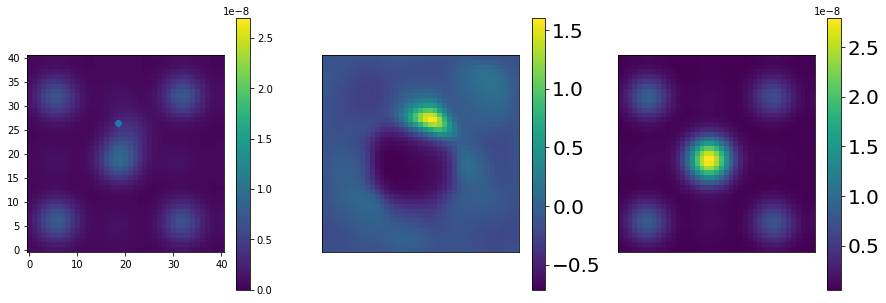

In [167]:
# plot for DOE poster, coordinates matches DFT model

simpath = '/srv/home/chenyu/antisite/PRISMATIC/'
depth=25
slice=0
temp =  np.load(simpath + 'Depth' + str(depth) + '/COM_depth' + str(depth) + '_slice' + str(slice) + '_90AnnularInt.npy')
temp2 = np.load(simpath + 'Depth' + str(depth) + '/AnnularIntDiffPct_depth_' + str(depth) + '_slice' + str(slice) + '.npy')
datacube_perfect = np.load(simpath+'Depth0/COM_depth0_slice' + str(26-depth+slice) + '_90AnnularInt.npy')


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

angle_low = 200
angle_high = 230

im0 = ax[0].imshow(np.mean(temp[:,:,angle_low:angle_high],axis=2),clim = [0,2.7e-8])
fig.colorbar(im0,ax=ax[0])
ax[0].scatter(18.5,26.5)

im1 = ax[1].imshow(np.mean(temp2[:,:,angle_low:angle_high],axis=2))
cbar1 = fig.colorbar(im1,ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
cbar1.ax.tick_params(labelsize=20) 

im2 = ax[2].imshow((np.mean(datacube_perfect[:,:,angle_low:angle_high],axis=2)))
cbar2 = fig.colorbar(im2,ax=ax[2])
ax[2].set_xticks([])
ax[2].set_yticks([])
cbar2.ax.tick_params(labelsize=20) 

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

# The shadow around Ti columns close to edge is probably artifact from convolution


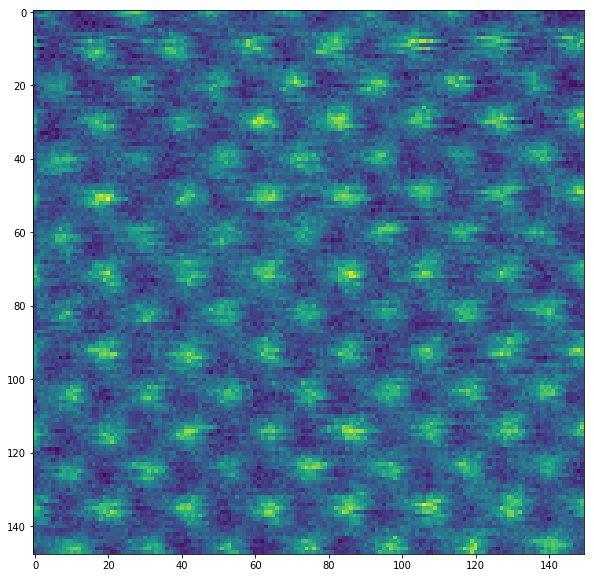

In [27]:
x = int(peaks_x[i])
y = int(peaks_y[i])+2
x_start = int(x + mask_center_1_exp[0] - (mask_size_1_exp[0]-1)/2)
y_start = int(y + mask_center_1_exp[1] - (mask_size_1_exp[1]-1)/2)
temp = np.sum(AnnularInt[:,:,222:250],axis=2)
plt.figure(figsize=(20,10))
plt.imshow(temp[1:-1,:])
# plt.scatter(x_start+mask_size_1_exp[0],y_start+mask_size_1_exp[1])

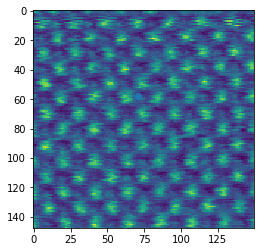

In [37]:
x = int(peaks_x[i])
y = int(peaks_y[i])+2
x_start = int(x + mask_center_1_exp[0] - (mask_size_1_exp[0]-1)/2)
y_start = int(y + mask_center_1_exp[1] - (mask_size_1_exp[1]-1)/2)

temp = np.sum(AnnularInt[:,:,21:40],axis=2)
plt.imshow(temp[1:-1,:])
plt.scatter(x_start,y_start)

In [2]:
depth = 18
target_thickness = 10
slice = thickness_target+depth-27

temp =  np.load(simpath + 'Depth' + str(depth) + '/COM_depth' + str(depth) + '_slice' + str(slice) + '_90AnnularInt.npy')
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

temp1 = temp[16:22,16:22,:]
lineprofile1 = np.average(temp1,axis=0)
lineprofile1 = np.average(lineprofile1,axis=0)

# im0 = ax[0].imshow(temp[19,:,0:54])
# fig.colorbar(im0,ax=ax[0])
# ax[0].scatter(47,10)

# difference = np.load(simpath + 'Depth' + str(depth) + '/' + savingName)
# im1 = ax[1].imshow(difference[19,:,0:54])
# fig.colorbar(im1,ax=ax[1])

temp = np.load(simpath+'Depth0/COM_depth0_slice' +str(26-depth+slice)+'_90AnnularInt.npy')
im2 = ax[2].imshow(temp[19,:,0:54])
fig.colorbar(im2,ax=ax[2])

temp2 = temp[16:22,16:22,:]
lineprofile2 = np.average(temp2,axis=0)
lineprofile2 = np.average(lineprofile2,axis=0)

# plt.xticks([])
# plt.yticks([])
# plt.show()

NameError: name 'thickness_target' is not defined

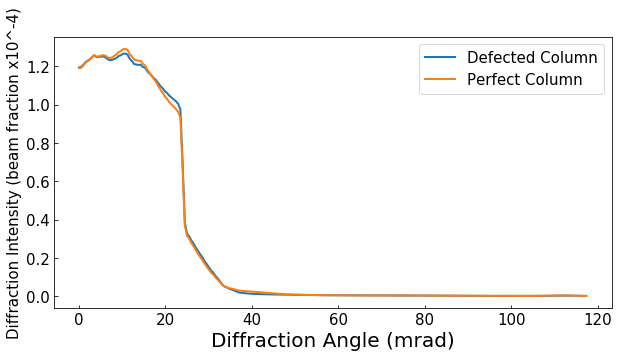

In [247]:
angle = np.linspace(0, 0.51*231, num=231, endpoint=False)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(angle,lineprofile1*10000, label = 'Defected Column', linewidth = '2')
ax.plot(angle,lineprofile2*10000, label = 'Perfect Column', linewidth = '2')
legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax.legend(loc='upper right',prop={'size': 15})
ax.tick_params(labelsize=15,direction='in')
ax.set_xlabel('Diffraction Angle (mrad)',fontsize=20)
ax.set_ylabel('Diffraction Intensity (beam fraction x10^-4)',fontsize=15)
plt.show()

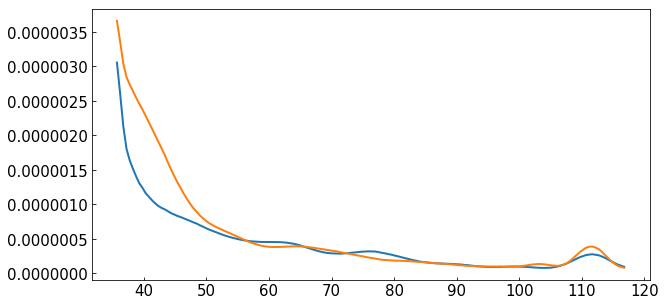

In [248]:
fig, ax = plt.subplots(figsize=(10,5))
# plt.plot(angle[70:-1],np.sqrt(lineprofile1[70:-1]),angle[70:-1],np.sqrt(lineprofile2[70:-1]),linewidth='2')
plt.plot(angle[70:-1],lineprofile1[70:-1],angle[70:-1],lineprofile2[70:-1],linewidth='2')
ax.tick_params(labelsize=15,direction='in')
# ax.set_yticks([])

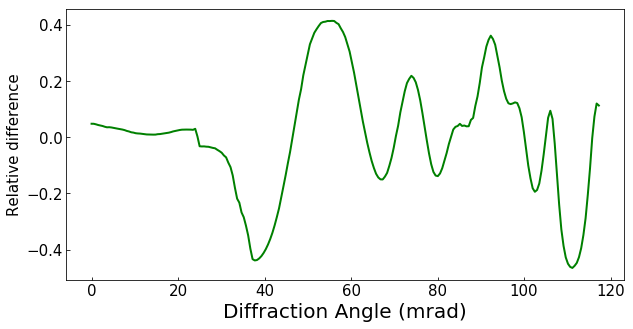

In [236]:
fig, ax = plt.subplots(figsize=(10,5),)
ax.plot(angle,(lineprofile1-lineprofile2)/lineprofile2, 'g', linewidth = '2')
ax.tick_params(labelsize=15,direction='in')
ax.set_xlabel('Diffraction Angle (mrad)',fontsize=20)
ax.set_ylabel('Relative difference',fontsize=15)
plt.show()

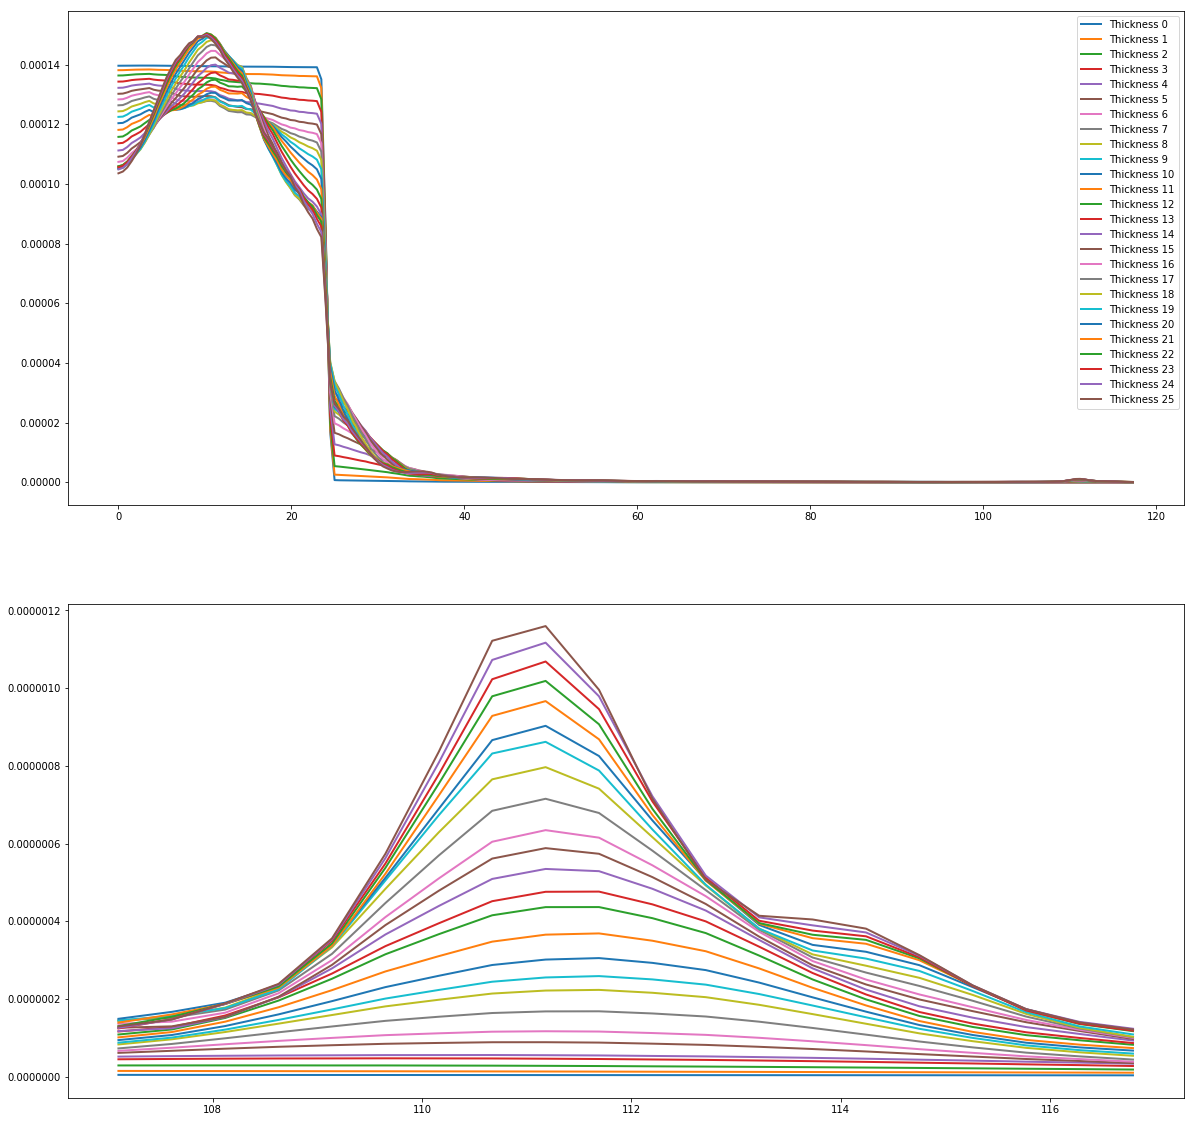

In [253]:
angle = np.linspace(0, 0.51*231, num=231, endpoint=False)
fig, ax = plt.subplots(2,1,figsize=(20,20))

for slice in range(26):
    temp = np.load(simpath+'Depth0/COM_depth0_slice' +str(slice)+'_90AnnularInt.npy')
    temp = temp[14:24,14:24,:]
    lineprofile = np.average(temp,axis=0)
    lineprofile = np.average(lineprofile,axis=0)
    ax[0].plot(angle,lineprofile,label = 'Thickness '+ str(slice), linewidth=2)
    ax[1].plot(angle[210:-1],lineprofile[210:-1],linewidth=2)
    
ax[0].legend(loc='upper right',prop={'size': 10})

0 0.00013174982200711682
1 0.00012899256316881117
2 0.00012543893681015166
3 0.0001215588493492996


KeyboardInterrupt: 

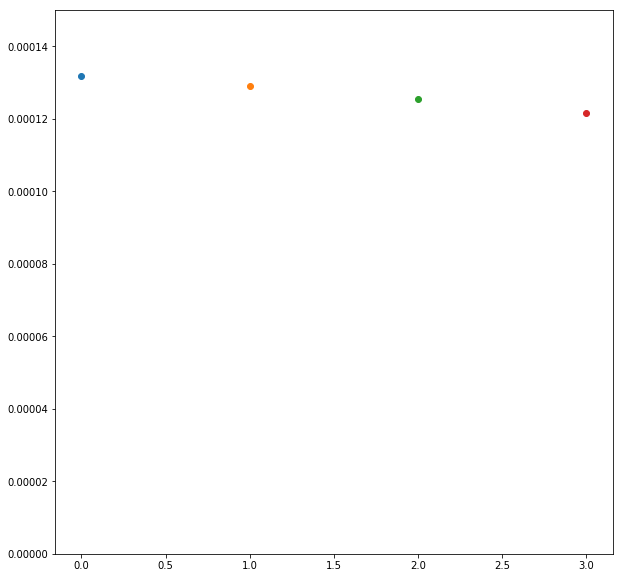

In [275]:
fig, ax = plt.subplots(figsize=(10,10))
for slice in range(26):
    temp = np.load(simpath+'Depth0/COM_depth0_slice' +str(slice)+'_90AnnularInt.npy')
    temp = temp[14:24,14:24,:]
    # normalize
    datacube = np.load(simpath + 'Depth0/depth0_slice'+str(slice)+'_90pmss.npy')
    temp2 = datacube[14:24,14:24,:,:]
    temp2 = np.sum(temp2,axis=2)
    temp2 = np.sum(temp2,axis=2)
    temp = temp/temp2
    
    lineprofile = np.average(temp,axis=0)
    lineprofile = np.average(lineprofile,axis=0)
#     print(slice,np.average(lineprofile[210:-1]))
#     ax.scatter(slice,np.average(lineprofile[210:-1]))
#     ax.set_ylim([0,1e-6])
    print(slice,np.average(lineprofile[40:48]))
    ax.scatter(slice,np.average(lineprofile[40:48]))
    ax.set_ylim([0,0.00015])

In [269]:
path = '/srv/home/chenyu/antisite/PRISMATIC/'
source_size = 90
depth = 0
slice = 15
datacube = np.load(path+'Depth'+str(depth)+'/depth'+str(depth)+'_slice'+str(slice)+'_'+str(source_size)+'pmss.npy')

In [276]:
temp2

array([[0.99885154, 0.99835575, 0.9978    , 0.9972952 , 0.99697214,
        0.99692583, 0.9971703 , 0.9976318 , 0.99818444, 0.99870706],
       [0.99833274, 0.9975457 , 0.99666023, 0.99585545, 0.99534106,
        0.9952699 , 0.9956632 , 0.9964014 , 0.99728227, 0.9981109 ],
       [0.9977379 , 0.9966131 , 0.99534476, 0.99419093, 0.9934542 ,
        0.99335426, 0.99392176, 0.99498266, 0.9962449 , 0.9974283 ],
       [0.9971844 , 0.9957428 , 0.994115  , 0.992633  , 0.9916871 ,
        0.99156046, 0.99229157, 0.9936558 , 0.99527645, 0.99679285],
       [0.9968169 , 0.99516356, 0.99329466, 0.99159265, 0.9905062 ,
        0.990361  , 0.9912014 , 0.9927687 , 0.99462944, 0.9963689 ],
       [0.99674606, 0.9950507 , 0.9931337 , 0.99138695, 0.9902714 ,
        0.99012136, 0.9909829 , 0.9925904 , 0.9944993 , 0.99628353],
       [0.99699473, 0.995441  , 0.9936842 , 0.99208295, 0.9910594 ,
        0.99092007, 0.9917077 , 0.99317944, 0.9949285 , 0.9965646 ],
       [0.99748576, 0.9962125 , 0.9947738